# **Table of Contents**
* [Explore & Wrangle](#section_20)
* [Assumptions Testing](#section_21)

* [Model Building](#section_22)
    * [LiR](#section_23)
    * [RF](#section_24)
    <br><br>
* [Model Selection](#section_25)
    * [Fitting](#section_26)
    * [Validation](#section_27)
    * [Best Model](#section_28)

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

import warnings
warnings.filterwarnings("ignore")


from   sklearn.linear_model     import   LinearRegression
from   sklearn.ensemble         import   RandomForestRegressor

from   sklearn.model_selection  import   train_test_split , KFold , cross_val_score , GridSearchCV
from   sklearn.metrics          import   mean_squared_error

<a id='section_20'></a>
# Part 1 - **Explore & Wrangle**

In [2]:
df  =  pd.read_csv ('datasets/Fish Weight.csv')

df.sample(5)

,Species,Weight,V_length,D_length,C_length,Height,Width
79,Perch,80.0,17.2,19.0,20.2,5.6358,3.0502
114,Perch,700.0,34.5,37.0,39.4,10.8350,6.2646
72,Perch,5.9,7.5,8.4,8.8,2.1120,1.4080
115,Perch,690.0,34.6,37.0,39.3,10.5717,6.3666
25,Bream,725.0,31.8,35.0,40.9,16.3600,6.0532


**Target Col -- Weight**

In [3]:
df.drop ( ['Species'] , axis=1 , inplace=True )

In [4]:
df.shape

(159, 6)

In [5]:
df.isnull().sum()

Weight      0
V_length    0
D_length    0
C_length    0
Height      0
Width       0
dtype: int64

<a id='section_21'></a>
# Part 2 - **Assumption Testing**

In [6]:
import statsmodels.api as sm

y  =  df['Weight']
x  =  df.drop('Weight', axis=1)
xc =  sm.add_constant(x)

model = sm.OLS(y,xc).fit()

## **1. Normality of residuals**

In [7]:
residuals  =  model.resid

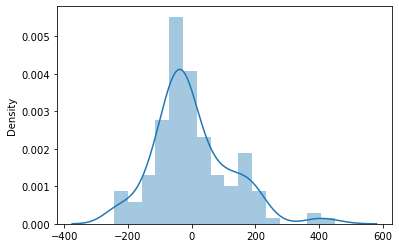

In [8]:
sns.distplot (residuals) ;

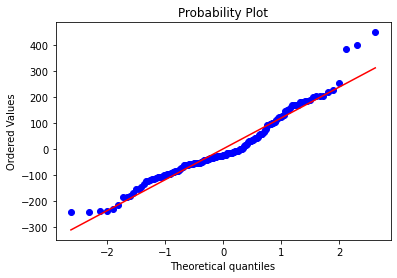

In [9]:
import scipy.stats  as stats

stats.probplot (residuals ,  plot=plt)
plt.show()

In [10]:
stats.jarque_bera (residuals)

(29.173861156680786, 4.623560468930421e-07)

>Comments :

        * test statistic , p-value
        * Residuals not normal
        * To achieve normal dist of residuals , apply boxcox transformation on target col.

In [11]:
df ['Weight']  , lmb   =   stats.boxcox ( df ['Weight'] )   

## **2. Low Multi-collinearity**

In [12]:
from   statsmodels.stats.outliers_influence   import   variance_inflation_factor   as   vif

score  =  [   vif (xc.values, i)        for i in  range(xc.shape[1])     ]

MC     =  pd.DataFrame (  {'VIF':score}  ,   index = xc.columns  )

MC.sort_values (by='VIF',ascending=False)

,VIF
D_length,2084.257828
V_length,1681.496487
C_length,422.468251
Height,14.570087
Width,12.275361
const,9.159520


> Comments :
    
        * Drop cols 1 by 1 , according to highest VIF value
        * After each drop , fit & recheck VIF
        * Process is continued untill there is no relationship between input variables.

In [13]:
df .drop ( ['D_length' , 'V_length'] , axis=1 , inplace=True )

In [14]:
import statsmodels.api as sm

y  =  df['Weight']
x  =  df.drop('Weight', axis=1)
xc =  sm.add_constant(x)

model = sm.OLS(y,xc).fit()

In [15]:
residuals  =  model.resid

## **3. Homo-scedasticity**

In [16]:
import statsmodels.stats.api as sms

sms.het_goldfeldquandt ( y=residuals , x=xc )

(0.7373921885259579, 0.9058489138193742, 'increasing')

> Comments :
        
        * H0 : Equal var of residuals ... (Homo)
        * H1 : Unequal var of residuals  ... (Hetero)
        * Output : test_statistic , p-value 
> Obs :
        
        * P > alpha
        * Accept Null
        * Homo-scedastic

## **4. No Auto-correlation**

In [17]:
from  statsmodels.stats.stattools  import  durbin_watson

durbin_watson (residuals)

1.6430641639820591

* Obs
    - Low auto-corr

## **5. Linearity**

In [18]:
import statsmodels.stats.api  as  sms

sms.diagnostic.linear_rainbow (model)

(3.1385785758603806, 5.913478397122869e-07)

> Comments :
        
        * H0 : Reg is Linear
        * H1 : Reg is not Linear.
        * Output : test_statistic , p-value 
> Obs :
        
        * P < alpha
        * Reject Null
        * Reg is not Linear

<a id='section_22'></a>
# Part 3 - **Model Building**

In [19]:
x  =  df.drop ('Weight' , axis=1)
y  =  df ['Weight']

x_train , x_test , y_train , y_test   =   train_test_split (x, y, test_size=0.3, random_state=42)

<a id='section_23'></a>
## **1 - LiR**

In [20]:
lr = LinearRegression()                                       

lr.fit (x_train , y_train)             

LinearRegression()

<a id='section_24'></a>
## **2 - RF**

In [21]:
kf  =  KFold ( n_splits =3 ,  shuffle =True ,  random_state =42 )

In [22]:
RF    =  RandomForestRegressor()

param =  { 'n_estimators':np.arange(1,15) , 'max_depth':np.arange(1,10) }

GS    =  GridSearchCV (RF , param , cv=kf , scoring='r2')

GS.fit (x_train , y_train)

GS.best_params_

{'max_depth': 6, 'n_estimators': 3}

In [23]:
RF = RandomForestRegressor ( n_estimators=3 , max_depth = 6 , random_state=0)  

RF.fit (x_train , y_train)

RandomForestRegressor(max_depth=6, n_estimators=3, random_state=0)

<a id='section_25'></a>
# Part 4 - **Model Selection**

In [24]:
models = []

models.append  (( 'LiR'     ,  lr      ))
models.append  (( 'RF'      ,  RF      ))

<a id='section_26'></a>
### **Fitting**

In [25]:
result = []

for i,j in models:

    print(i)
    
    y_train_pred  =  j.predict (x_train)
    y_test_pred   =  j.predict (x_test)
                   
    print  (  ( mean_squared_error  ( y_train , y_train_pred )) **0.5    )                                 
    print  (  ( mean_squared_error  ( y_test  , y_test_pred  )) **0.5    )

LiR
0.6931803111360729
0.7542671574801487
RF
0.522975126835873
0.9059357098996982


<a id='section_27'></a>
### **Validation**

In [26]:
result = []

for  i,j  in  models:
    
    score = cross_val_score ( j , x_train , y_train , cv =kf, scoring ='r2' )
    
    result.append ( { 'Name': i   ,   'BE': np.mean(1-score)   ,   'VE': np.std(score,ddof=1)  } )                


table = pd.DataFrame(result)
table

,Name,BE,VE
0,LiR,0.014599,0.006537
1,RF,0.040801,0.009696


<a id='section_28'></a>
### **Best Model**

## *Linear Regressor*